In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
import glob
from pathlib import Path

In [8]:
def read_vx(file, data_str):
    idl_dict = readsav(file)
    vx = idl_dict[data_str]
    return vx

dv = 0.04
drifts = np.arange(-0.2, 0.21, dv)

In [59]:
datadir = os.path.expanduser('~/Data/Karin/sanity_check')
lctfiles0 = list(Path(os.path.join(datadir, 'Stein-simulation-series')).rglob('flct-km-Stein-simul-*.save'))
lctfiles1 = list(Path(os.path.join(datadir, 'flct-tests-skip/Stein-simulation-2skip')).rglob('flct-km-Stein-simul-*.save'))
lctfiles2 = list(Path(os.path.join(datadir, 'flct-tests-skip/Stein-simulation-3skip')).rglob('flct-km-Stein-simul-*.save'))
lctfiles0.sort()
lctfiles1.sort()
lctfiles2.sort()
lctfiles = [lctfiles0, lctfiles1, lctfiles2]
for filelist in lctfiles:
    for f in filelist:
        print(f)

/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_00/flct-km-Stein-simul-drift_00-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_01/flct-km-Stein-simul-drift_01-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_02/flct-km-Stein-simul-drift_02-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_03/flct-km-Stein-simul-drift_03-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_04/flct-km-Stein-simul-drift_04-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_05/flct-km-Stein-simul-drift_05-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_06/flct-km-Stein-simul-drift_06-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_07/flct-km-Stein-simul-drift_07-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_08/f

['<', 'g', 'e', 'n', 'e', 'r', 'a', 't', 'o', 'r', ' ', 'o', 'b', 'j', 'e', 'c', 't', ' ', 'P', 'a', 't', 'h', '.', 'r', 'g', 'l', 'o', 'b', ' ', 'a', 't', ' ', '0', 'x', '1', '1', '2', 'c', '7', 'b', '7', 'd', '8', '>']


In [51]:
str(lctfiles2[0])

'/Users/rattie/Data/Karin/sanity_check/flct-tests-skip/Stein-simulation-3skip/drift_07/flct-km-Stein-simul-drift_07-dt3-dx7pix.save'

In [31]:

dts = [1, 2, 3]
namestr = ['vxmsdt{:d}'.format(dt) for dt in dts]
vxs = [read_vx(file, namestr) for file, namestr in zip(lctfiles, namestr)]
print(vxs[0].shape)

IndexError: list index out of range

## Shifts between two different images spaced  by different time gaps,  scale = 15 px

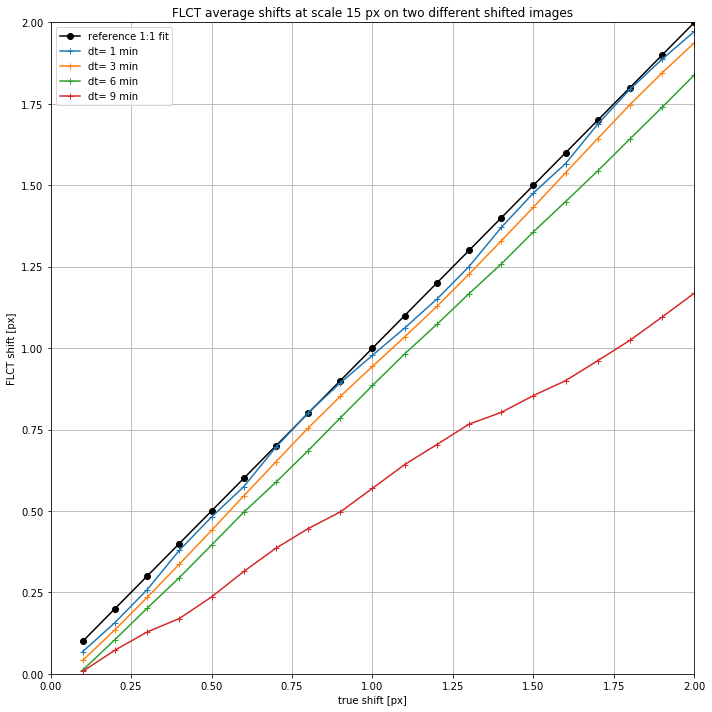

In [15]:
scale_idx = 5
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.plot(drifts, drifts, 'k-', marker='o', label='reference 1:1 fit')
for i, dt in enumerate(dts):
    ax.plot(drifts, vxs[i][scale_idx,:], marker='+', label = 'dt= {:d} min'.format(dt))
ax.grid(True, axis='both')
plt.xlabel('true shift [px]')
plt.ylabel('FLCT shift [px]')
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.legend()
plt.title('FLCT average shifts at scale {:d} px on two different shifted images'.format(flct_scales[scale_idx]))
plt.tight_layout()
plt.savefig('/Users/rattie/Data/Ben/SteinSDO/calibration/sanity_check_shifted_images/flct_shifts_diff_images.png', dpi=300)

### Look at the discrepancies

In [30]:
errors = [[drifts - vx[sidx,:] for sidx in range(len(flct_scales))] for vx in vxs]

In [28]:
len(errors)

4

In [29]:
len(errors[0])

11